In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F
import pathlib


cudnn.benchmark = True
plt.ion()   # interactive mode

In [44]:
# Hyper-parameters 
num_epochs = 15
batch_size = 4
learning_rate = 0.001

In [42]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
   
val_transform =transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


train_path = 'data/cat_dog/train'
val_path = 'data/cat_dog/test'
trainset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(val_path, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
root=pathlib.Path(train_path)
classNames=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classNames)

['cat', 'dog']


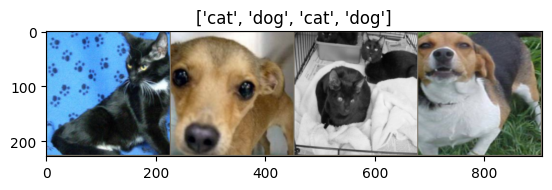

In [45]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[classNames[x] for x in labels])

In [46]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 6, 220, 220])
torch.Size([4, 6, 110, 110])
torch.Size([4, 16, 106, 106])
torch.Size([4, 16, 53, 53])


In [47]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classNames))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [49]:
train_losses, val_losses = [], []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # Move inputs and labels to the device
            inputs, labels = data[0].to(device), data[1].to(device)
         
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(testloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


print('Finished Training')

Epoch 1/15 - Train loss: 0.6711419074714183, Validation loss: 0.6260518213808537
Epoch 2/15 - Train loss: 0.6345383052885533, Validation loss: 0.572858086720109
Epoch 3/15 - Train loss: 0.6052794939473272, Validation loss: 0.535620626822114
Epoch 4/15 - Train loss: 0.5827866875395179, Validation loss: 0.5267121077254414
Epoch 5/15 - Train loss: 0.5702191329017281, Validation loss: 0.4965139157641679
Epoch 6/15 - Train loss: 0.5584682149581611, Validation loss: 0.4667183296121657
Epoch 7/15 - Train loss: 0.5510787925183773, Validation loss: 0.4908183965235949
Epoch 8/15 - Train loss: 0.5378402411215008, Validation loss: 0.46074475199729203
Epoch 9/15 - Train loss: 0.5308242907002568, Validation loss: 0.459871361207217
Epoch 10/15 - Train loss: 0.5223468331526965, Validation loss: 0.4722829765751958
Epoch 11/15 - Train loss: 0.5130859100580215, Validation loss: 0.43653010844253004
Epoch 12/15 - Train loss: 0.5120078771133907, Validation loss: 0.4337120524682105
Epoch 13/15 - Train loss: 

In [50]:
def train_model(model, scheduler):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(trainset)
                epoch_acc = running_corrects.double() / len(trainset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [51]:
model_fit = train_model(net,  exp_lr_scheduler)

Epoch 0/14
----------
train Loss: 0.4847 Acc: 0.7625
val Loss: 0.4798 Acc: 0.7646

Epoch 1/14
----------
train Loss: 0.4852 Acc: 0.7631
val Loss: 0.4788 Acc: 0.7642

Epoch 2/14
----------
train Loss: 0.4813 Acc: 0.7641
val Loss: 0.5111 Acc: 0.7450

Epoch 3/14
----------
train Loss: 0.4767 Acc: 0.7656
val Loss: 0.4643 Acc: 0.7757

Epoch 4/14
----------
train Loss: 0.4712 Acc: 0.7696
val Loss: 0.4715 Acc: 0.7798

Epoch 5/14
----------
train Loss: 0.4700 Acc: 0.7705
val Loss: 0.4743 Acc: 0.7627

Epoch 6/14
----------
train Loss: 0.4657 Acc: 0.7740
val Loss: 0.4554 Acc: 0.7792

Epoch 7/14
----------
train Loss: 0.4334 Acc: 0.7946
val Loss: 0.4292 Acc: 0.7952

Epoch 8/14
----------
train Loss: 0.4348 Acc: 0.7927
val Loss: 0.4312 Acc: 0.7944

Epoch 9/14
----------
train Loss: 0.4339 Acc: 0.7912
val Loss: 0.4295 Acc: 0.7969

Epoch 10/14
----------
train Loss: 0.4252 Acc: 0.7990
val Loss: 0.4225 Acc: 0.7980

Epoch 11/14
----------
train Loss: 0.4269 Acc: 0.7961
val Loss: 0.4190 Acc: 0.8040

Ep

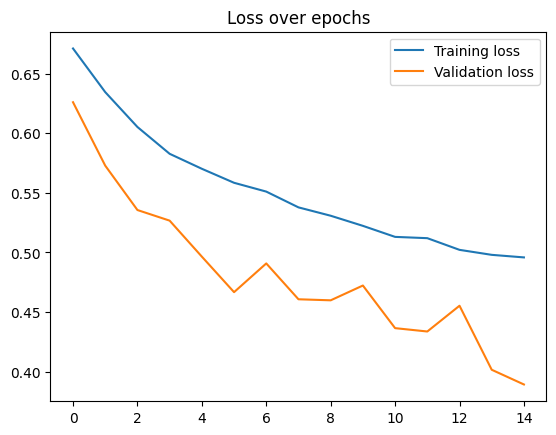

[0.6711419074714183, 0.6345383052885533, 0.6052794939473272, 0.5827866875395179, 0.5702191329017281, 0.5584682149581611, 0.5510787925183773, 0.5378402411215008, 0.5308242907002568, 0.5223468331526965, 0.5130859100580215, 0.5120078771133907, 0.502207998643443, 0.4980193714991212, 0.49587221730053427]
[0.6260518213808537, 0.572858086720109, 0.535620626822114, 0.5267121077254414, 0.4965139157641679, 0.4667183296121657, 0.4908183965235949, 0.46074475199729203, 0.459871361207217, 0.4722829765751958, 0.43653010844253004, 0.4337120524682105, 0.4553287254590541, 0.4016176129747182, 0.38926942726876584]


In [52]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()
print(train_losses)
print(val_losses)

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classNames[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

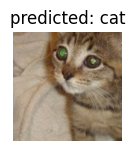

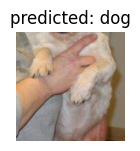

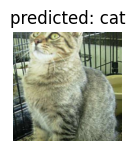

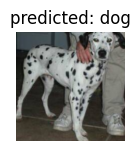

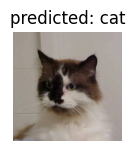

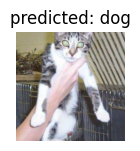

In [54]:
visualize_model(model_fit)

In [55]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model_fit(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 85 %


In [56]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classNames}
total_pred = {classname: 0 for classname in classNames}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_fit(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classNames[label]] += 1
            total_pred[classNames[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: cat   is 84.2 %
Accuracy for class: dog   is 87.2 %


In [57]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = val_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {classNames[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

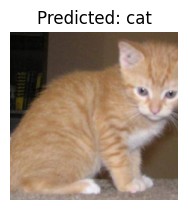

In [59]:
visualize_model_predictions(
    model_fit,
    img_path='data/cat_dog/val/cat.4003.jpg'
)

plt.ioff()
plt.show()

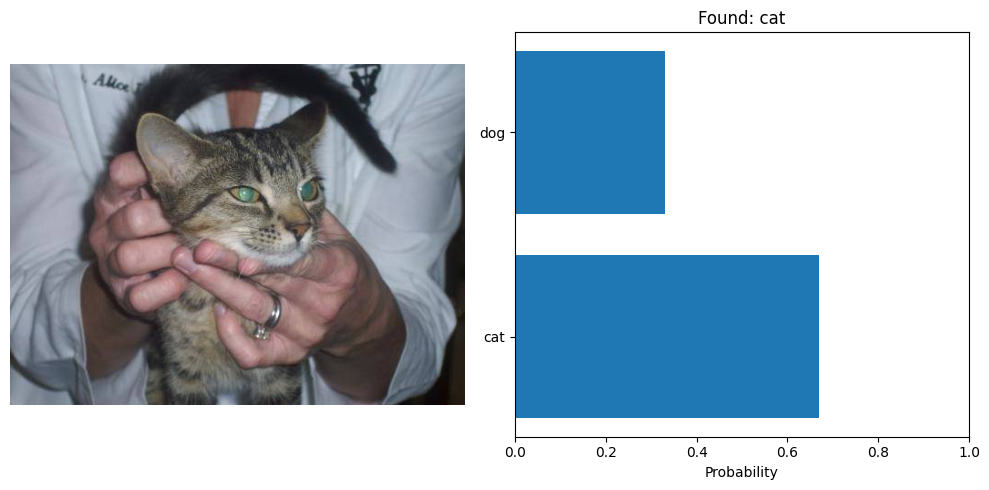

In [61]:
# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image, val_transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    found_classes = []
    for i, x in enumerate(classNames):
        if(probabilities[i] > 0.5):
            found_classes.append(x)
    if(found_classes == []):
        found_classes.append('none')

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Found: " + ', '.join(found_classes))
    axarr[1].set_xlim(0, 1)

 

    plt.tight_layout()
    plt.show()

test_image = "data/cat_dog/val/cat.4025.jpg"


original_image, image_tensor = preprocess_image(test_image)
probabilities = predict(model_fit, image_tensor, device)


visualize_predictions(original_image, probabilities, classNames)

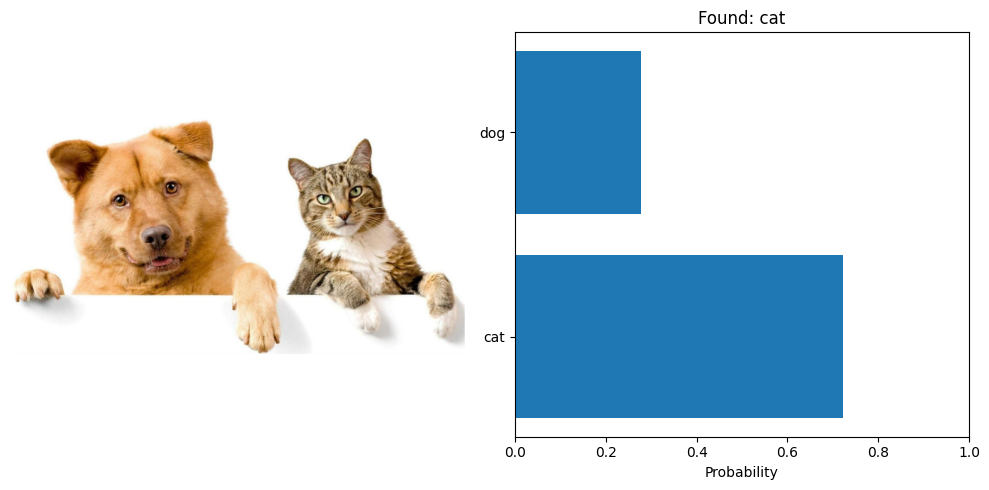

In [73]:
test_image = "data/cat_dog/other/dog-and-cat-cover.jpg"


original_image, image_tensor = preprocess_image(test_image)
probabilities = predict(model_fit, image_tensor, device)


visualize_predictions(original_image, probabilities, classNames)

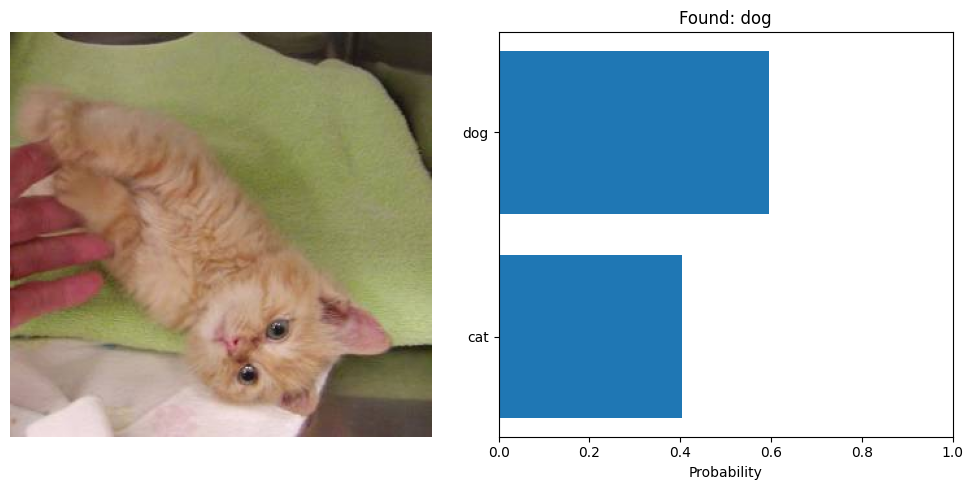

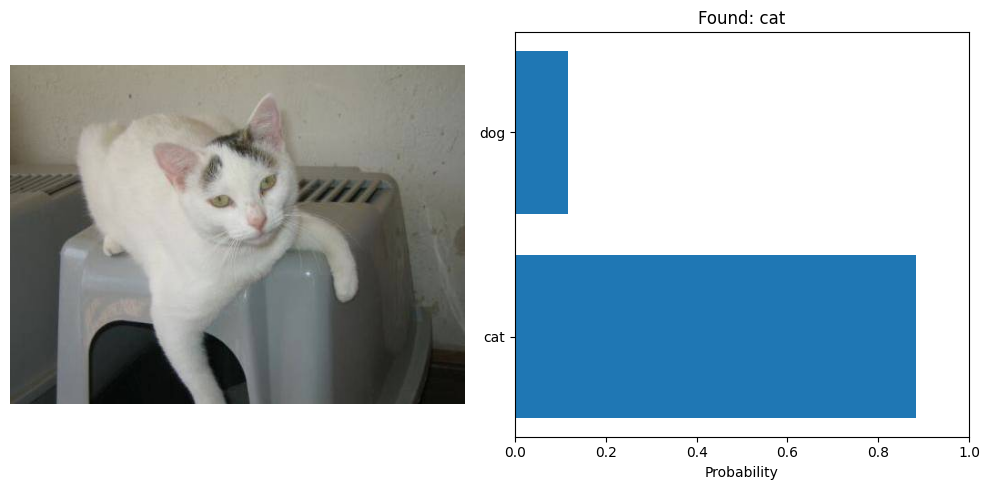

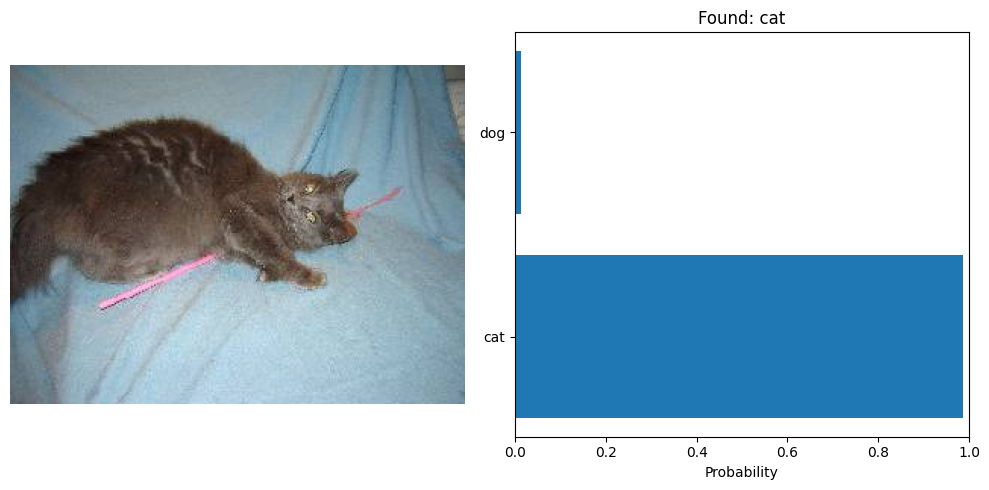

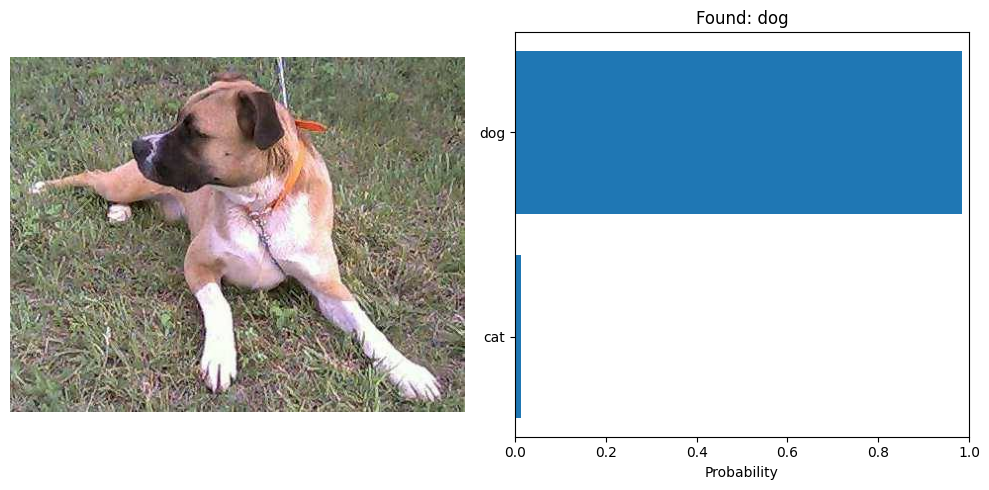

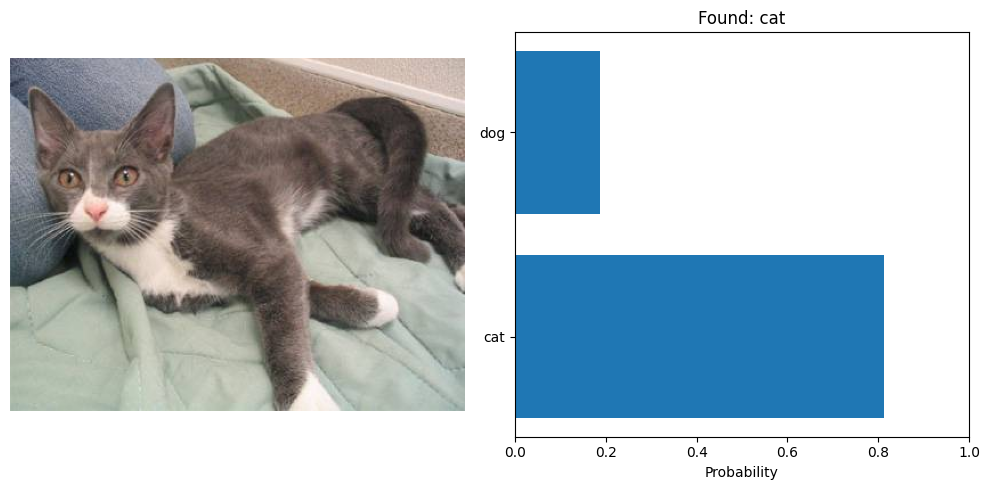

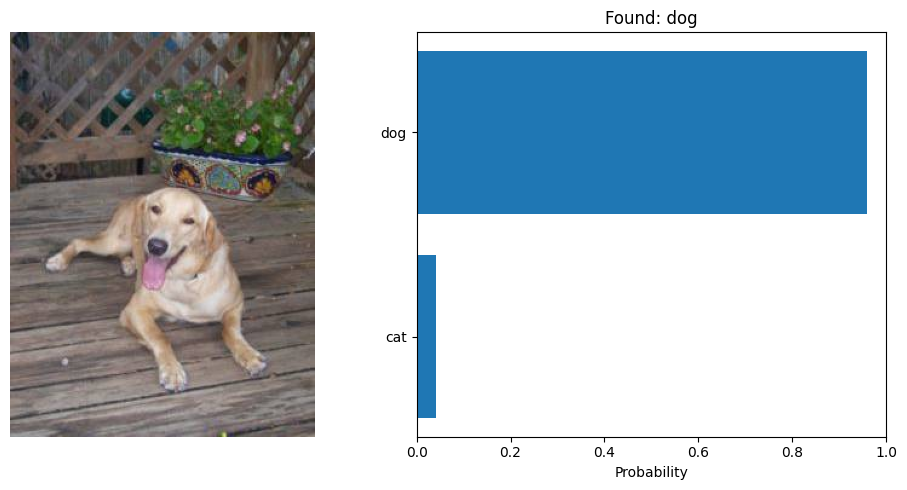

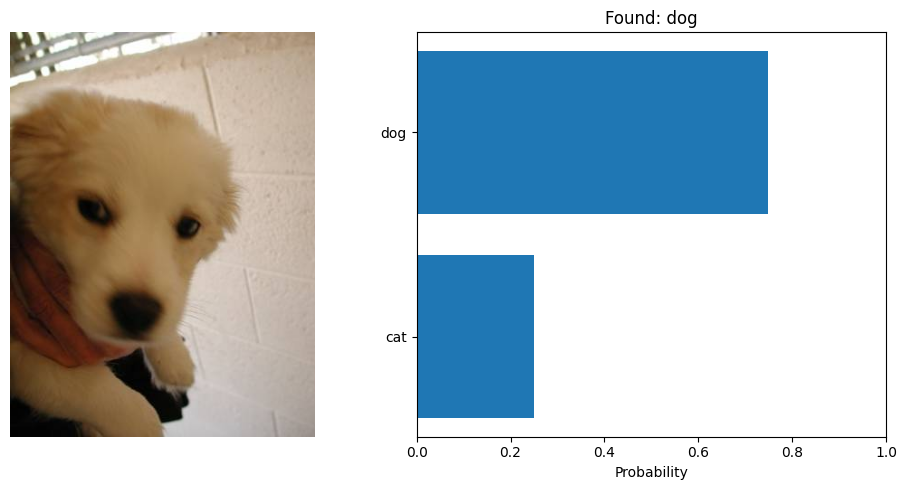

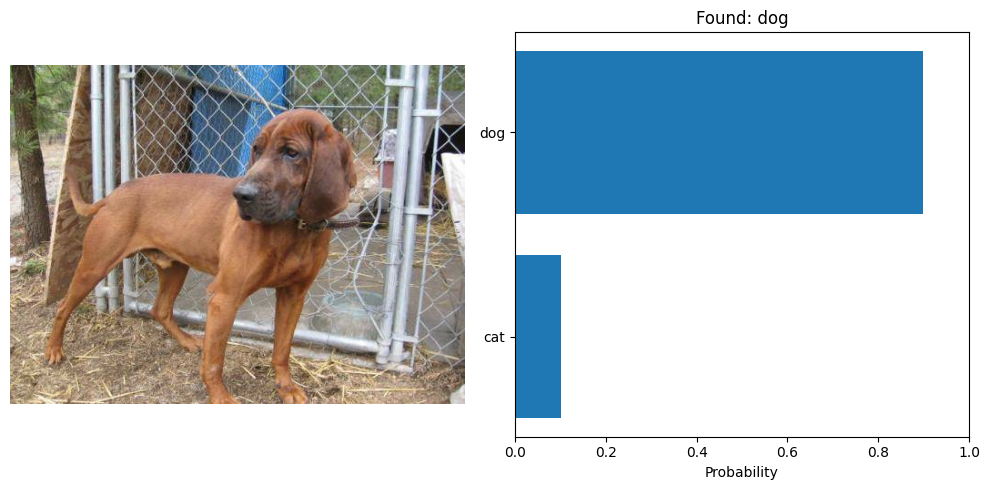

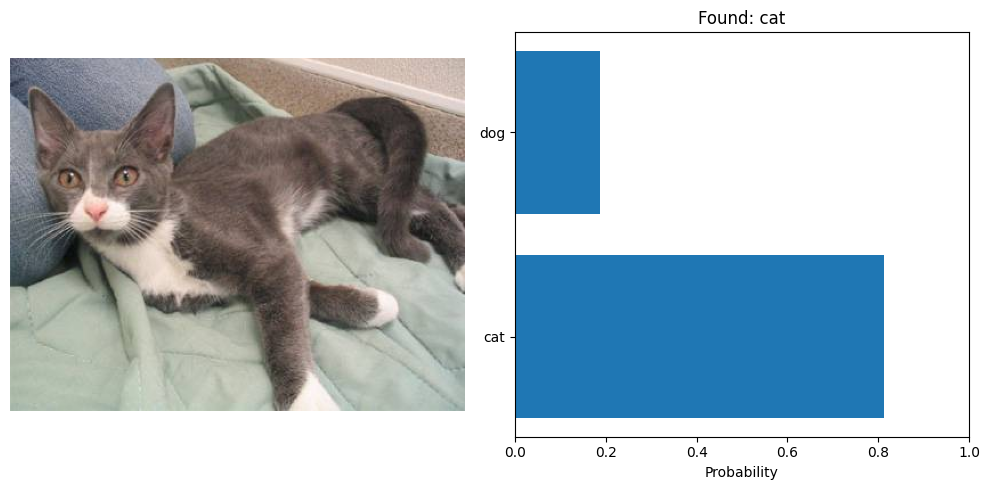

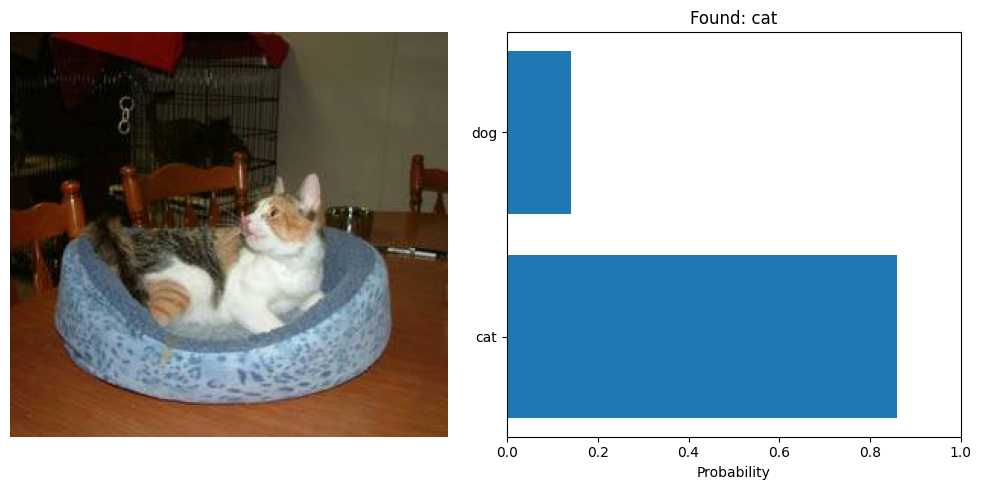

In [72]:
from glob import glob
test_images = glob('data/cat_dog/val/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example)
    probabilities = predict(model_fit, image_tensor, device)
 
    visualize_predictions(original_image, probabilities, classNames)